In [1]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from pyuvdata import UVData
from matplotlib.colors import LogNorm

from numpy.fft import fftshift, fftfreq, fft
from scipy import signal

from itertools import combinations_with_replacement

In [2]:
def get_vis_data(files,jd_range):
    
    uvd = UVData()
    if len(files)>1:
        uvd.read(files,axis='freq',time_range=jd_range)
    else:
        uvd.read(files,time_range=jd_range)

    ants = uvd.get_ants()
    pols = uvd.get_pols()
    Nbl = uvd.Nbls
    freqs = (uvd.freq_array)[0]
    lsts = np.unique(uvd.lst_array)*180./(15.*np.pi)
    uvw = (uvd.uvw_array).reshape(-1,Nbl,3)
    bls = np.sqrt(np.sum(uvw[0]**2,axis=1))
    bls = bls[bls!=0.]
    
    autos = np.zeros((3,2,len(lsts),len(freqs)),dtype=np.complex)
    cross = np.zeros((3,2,len(lsts),len(freqs)),dtype=np.complex)

    cross_IDs = []

    i = 0
    j = 0

    for ant1, ant2 in combinations_with_replacement(ants, 2):
        if ant1==ant2:
            autos[i,0] = uvd.get_data([ant1,ant2,'xx'])
            autos[i,1] = uvd.get_data([ant1,ant2,'yy'])
            i+=1
        else:
            cross_IDs.append([ant1,ant2])
            cross[j,0] = uvd.get_data([ant1,ant2,'xx'])
            cross[j,1] = uvd.get_data([ant1,ant2,'yy'])
            j+=1
    return autos, cross, cross_IDs, freqs, lsts, ants, bls, pols

def calculate_delayspec(autos, cross, freqs):
    
    window = signal.blackmanharris(len(freqs))[np.newaxis,np.newaxis,np.newaxis,:]
    
    F_autos = fftshift(fft(autos*window,axis=3),axes=3)
    F_cross = fftshift(fft(cross*window,axis=3),axes=3)
    
    tau = fftshift(fftfreq(len(freqs),d=freqs[1]-freqs[0]))

    return F_autos, F_cross, tau

def dB(x):
    return 10*np.log10(x/np.amax(x))


def colorbar_plotter(fig,ax,im,label):
        
    pos = ax.get_position()
    cbarax = fig.add_axes([pos.x0 + pos.width+0.01, pos.y0, 0.008, pos.height])

    cbar = fig.colorbar(im,cax=cbarax)

    cbar.ax.tick_params(labelsize=16) 
    cbar.ax.set_ylabel(label,fontsize=16)
    
    return cbar

In [3]:
JDstart = 2458116.24485307
JDend = JDstart + (22./24.)

files_nocc_1src = np.sort(glob('/data7/pyuvsim_results/Cross-coupling-beam-sims/results/HERA_no-cc-3ant_1src_spw1_820ch-24h.uvh5'))
files_nocc_2src = np.sort(glob('/data7/pyuvsim_results/Cross-coupling-beam-sims/results/HERA_no-cc-3ant_2src_spw1_820ch-24h.uvh5'))

files_cc_1src = np.sort(glob('/data7/pyuvsim_results/Cross-coupling-beam-sims/results/HERA_cc-3ant_1src_spw*_410ch-24hr.uvh5'))
files_cc_2src = np.sort(glob('/data7/pyuvsim_results/Cross-coupling-beam-sims/results/HERA_cc-3ant_2src_spw*_410ch-24hr.uvh5'))


In [4]:
autos_nocc_1src, cross_nocc_1src, cross_IDs, freqs, lsts, ants, bls, pols = get_vis_data(files_nocc_1src,[JDstart,JDend])
autos_nocc_2src, cross_nocc_2src, _, _, _, _, _, _ = get_vis_data(files_nocc_2src,[JDstart,JDend])
autos_cc_1src, cross_cc_1src, _, _, _, _, _, _ = get_vis_data(files_cc_1src,[JDstart,JDend])
autos_cc_2src, cross_cc_2src, _, _, _, _, _, _ = get_vis_data(files_cc_2src,[JDstart,JDend])

antenna_diameters is not set. Using known values for HERA.
antenna_diameters is not set. Using known values for HERA.
antenna_diameters is not set. Using known values for HERA.
antenna_diameters is not set. Using known values for HERA.
antenna_diameters is not set. Using known values for HERA.
antenna_diameters is not set. Using known values for HERA.


In [5]:
src1_idx = np.where(autos_nocc_1src[0,0,:,0]!=0.)
src2_idx = np.where(autos_nocc_2src[0,0,:,0]!=0.)

lst_1src = lsts[src1_idx[0]]
lst_2src = lsts[src2_idx[0]]

In [6]:
F_autos_nocc1, F_cross_nocc1, tau = calculate_delayspec(autos_nocc_1src[:,:,src1_idx[0],:], cross_nocc_1src[:,:,src1_idx[0],:], freqs)
F_autos_nocc2, F_cross_nocc2, _ = calculate_delayspec(autos_nocc_2src[:,:,src2_idx[0],:], cross_nocc_2src[:,:,src2_idx[0],:], freqs)

F_autos_cc1, F_cross_cc1, _ = calculate_delayspec(autos_cc_1src[:,:,src1_idx[0],:], cross_cc_1src[:,:,src1_idx[0],:], freqs)
F_autos_cc2, F_cross_cc2, _ = calculate_delayspec(autos_cc_2src[:,:,src2_idx[0],:], cross_cc_2src[:,:,src2_idx[0],:], freqs)

In [7]:
def delayspec_plotter(spectrum,tau_grid,lst_grid,bls,title_str, supertitle):
    fig, axs = plt.subplots(nrows=2,ncols=3,figsize=(22,12))
    fig.subplots_adjust(wspace=0.1,hspace=0.15)
    fig.suptitle(supertitle,fontsize=18)

    if bls is not None:
        t_horizon = 1.e9*bls/3.e8
    
    for i in range(2):
        for j in range(3):        
            axim = axs[i,j].pcolormesh(tau_grid,lst_grid,dB(abs(spectrum[j,i])),vmin=-100,vmax=0,cmap='Spectral_r')
            if bls is not None:
                axs[i,j].axvline(t_horizon[j],c='k',ls='--',lw=2)
                axs[i,j].axvline(-1.*t_horizon[j],c='k',ls='--',lw=2)
            axs[i,j].tick_params(axis='both',direction='in',which='both',labelsize=14)
            axs[i,j].set_xlim(-1500.,1500.)
            if i==0:
                axs[i,j].set_title(title_str[j],fontsize=16)
                if j==0:
                    axs[i,j].set_ylabel('E-pol\n'+r'LST$\,[$h$]$',fontsize=16)
            else:
                axs[i,j].set_xlabel(r'$\tau\,[$ns$]$',fontsize=16)        
                if j==0:
                    axs[i,j].set_ylabel('N-pol\n'+r'LST$\,[$h$]$',fontsize=16)
        
        if j==2:
            colorbar_plotter(fig,axs[i,j],axim,r'dB')
            

def delayrate_spec_plotter(spectrum,tau_grid,ft_grid,bls,title_str, supertitle):
    fig, axs = plt.subplots(nrows=2,ncols=3,figsize=(22,12))
    fig.subplots_adjust(wspace=0.1,hspace=0.15)
    fig.suptitle(supertitle,fontsize=18)
    
    if bls is not None:
        t_horizon = 1.e9*bls/3.e8
    
    for i in range(2):
        for j in range(3):        
            axim = axs[i,j].pcolormesh(tau_grid,ft_grid,dB(abs(spectrum[j,i])),vmin=-100,vmax=0,cmap='Spectral_r')
            if bls is not None:
                axs[i,j].axvline(t_horizon[j],c='k',ls='--',lw=2)
                axs[i,j].axvline(-1.*t_horizon[j],c='k',ls='--',lw=2)
            axs[i,j].tick_params(axis='both',direction='in',which='both',labelsize=14)
            axs[i,j].set_xlim(-1500.,1500.)
            axs[i,j].set_ylim(-0.02,0.02)
            if i==0:
                axs[i,j].set_title(title_str[j],fontsize=16)
                if j==0:
                    axs[i,j].set_ylabel('E-pol\n'+r'f$\,[$Hz$]$',fontsize=16)
            else:
                axs[i,j].set_xlabel(r'$\tau\,[$ns$]$',fontsize=16)        
                if j==0:
                    axs[i,j].set_ylabel('N-pol\n'+r'f$\,[$Hz$]$',fontsize=16)
        
        if j==2:
            colorbar_plotter(fig,axs[i,j],axim,r'dB')
            


In [8]:
t1_g, lst1_g = np.meshgrid(tau*1.e9,lst_1src)
t2_g, lst2_g = np.meshgrid(tau*1.e9,lst_2src)

autos_str = [r'ANT1','ANT2',r'ANT3']
cross_str = [r'ANT1-ANT2','ANT1-ANT3',r'ANT2-ANT3']

Text(0.5, 1.0, 'N-pol')

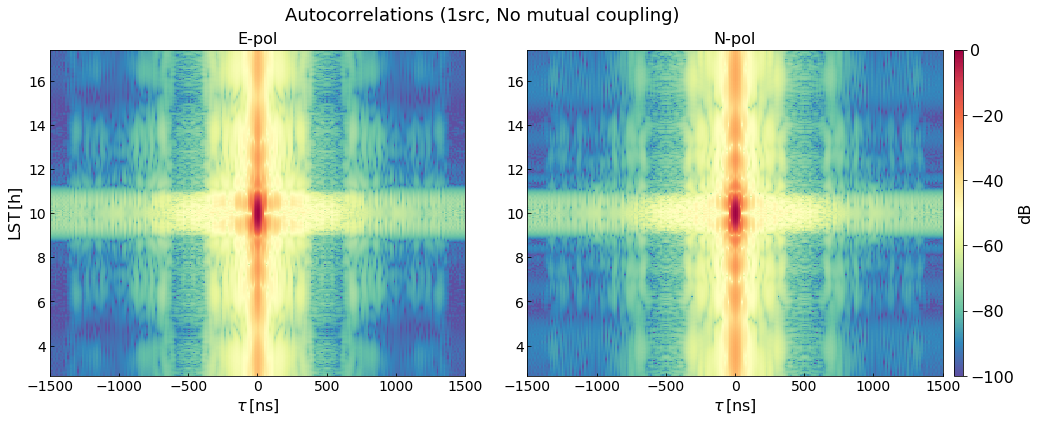

In [9]:
fig1, axs = plt.subplots(nrows=1,ncols=2,figsize=(16,6))
fig1.subplots_adjust(wspace=0.15)
fig1.suptitle(r'Autocorrelations (1src, No mutual coupling)',fontsize=18)

for i in range(2):        
    axim = axs[i].pcolormesh(t1_g,lst1_g,dB(abs(F_autos_nocc1[0,i])),vmin=-100,vmax=0,cmap='Spectral_r')    
    axs[i].tick_params(axis='both',direction='in',which='both',labelsize=14)
    axs[i].set_xlim(-1500.,1500.)
    axs[i].set_xlabel(r'$\tau\,[$ns$]$',fontsize=16)     
    
    if i==0:
        axs[i].set_ylabel(r'LST$\,[$h$]$',fontsize=16)
    else:
        colorbar_plotter(fig1,axs[i],axim,r'dB')
         
axs[0].set_title(r'E-pol',fontsize=16)
axs[1].set_title(r'N-pol',fontsize=16)

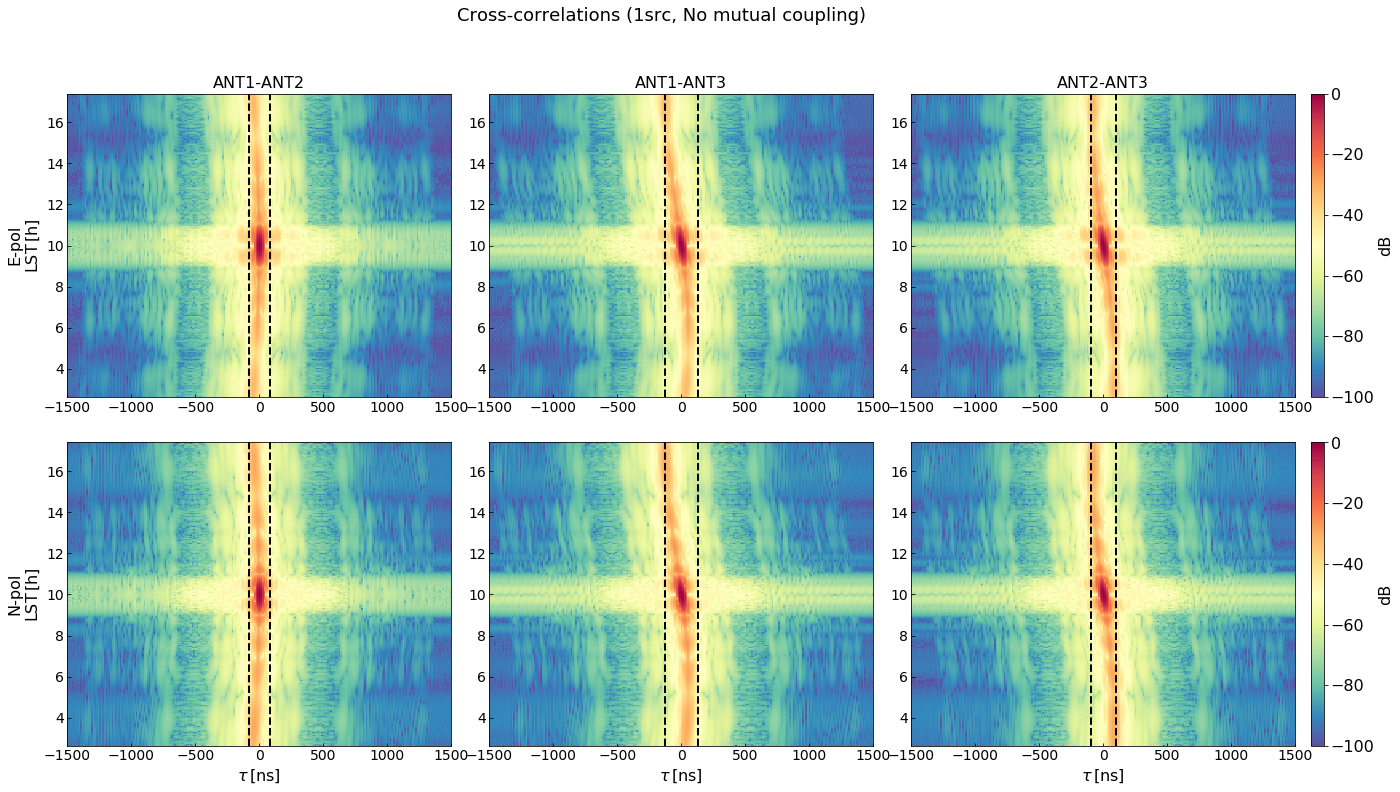

In [10]:
delayspec_plotter(F_cross_nocc1,t1_g,lst1_g,bls,cross_str,r'Cross-correlations (1src, No mutual coupling)')

Text(0.5, 1.0, 'N-pol')

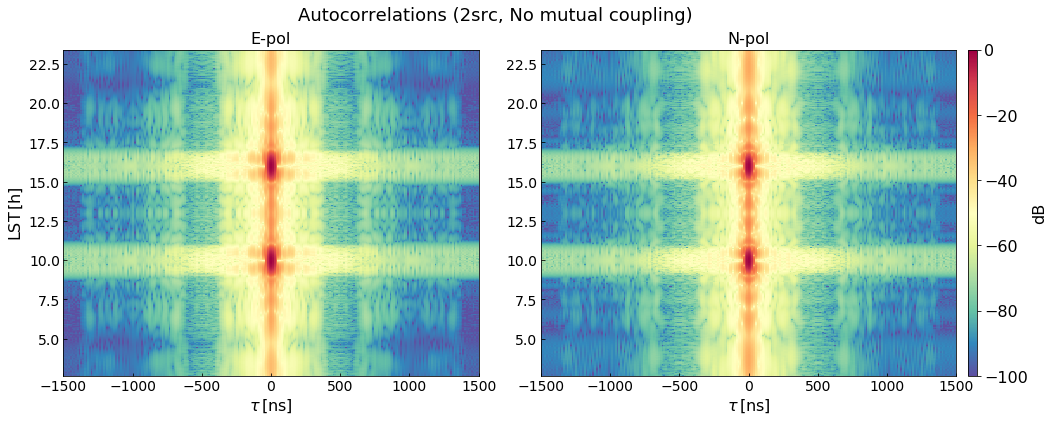

In [11]:
fig2, axs = plt.subplots(nrows=1,ncols=2,figsize=(16,6))
fig2.subplots_adjust(wspace=0.15)
fig2.suptitle(r'Autocorrelations (2src, No mutual coupling)',fontsize=18)

for i in range(2):        
    axim = axs[i].pcolormesh(t2_g,lst2_g,dB(abs(F_autos_nocc2[0,i])),vmin=-100,vmax=0,cmap='Spectral_r')    
    axs[i].tick_params(axis='both',direction='in',which='both',labelsize=14)
    axs[i].set_xlim(-1500.,1500.)
    axs[i].set_xlabel(r'$\tau\,[$ns$]$',fontsize=16)     
    
    if i==0:
        axs[i].set_ylabel(r'LST$\,[$h$]$',fontsize=16)
    else:
        colorbar_plotter(fig2,axs[i],axim,r'dB')
         
axs[0].set_title(r'E-pol',fontsize=16)
axs[1].set_title(r'N-pol',fontsize=16)

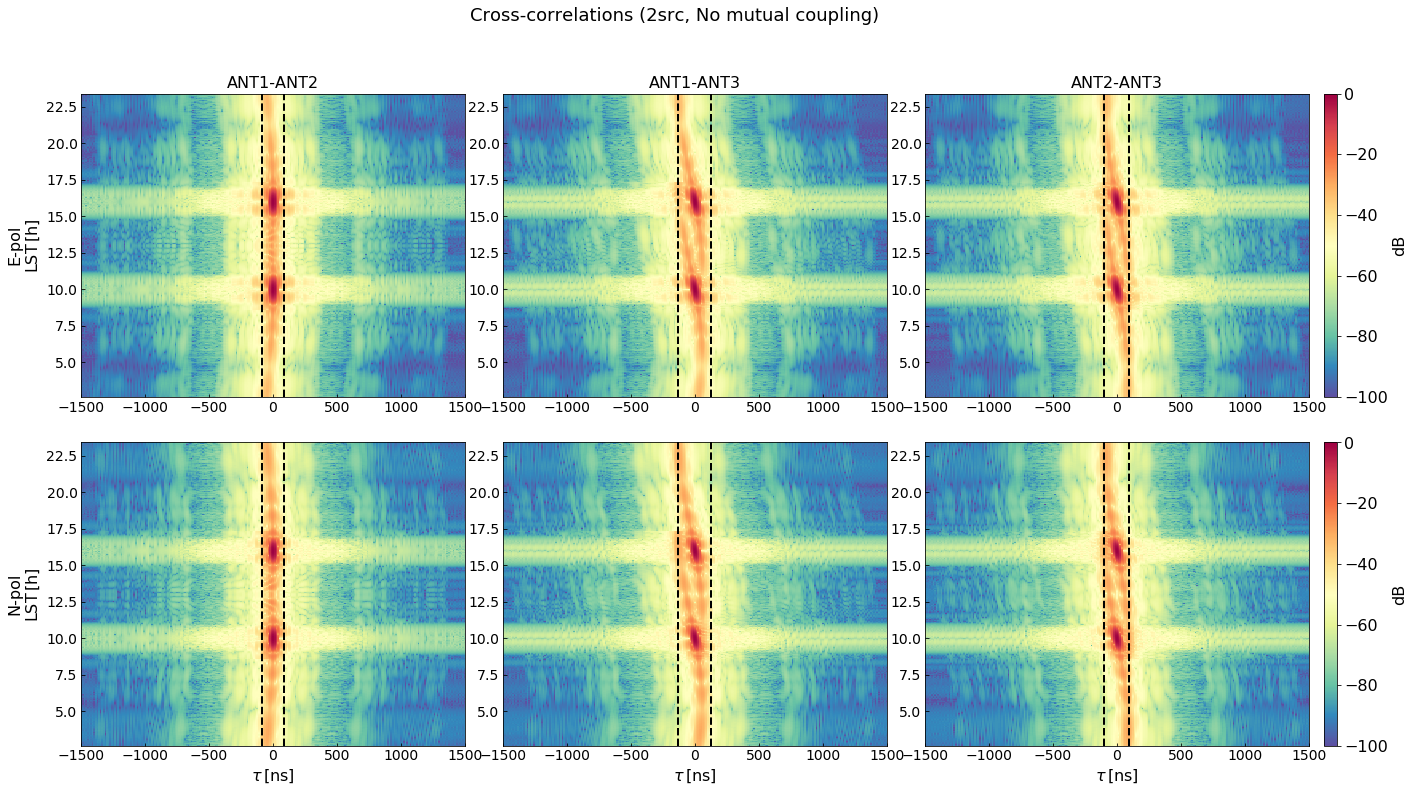

In [12]:
delayspec_plotter(F_cross_nocc2,t2_g,lst2_g,bls,cross_str,r'Cross-correlations (2src, No mutual coupling)')

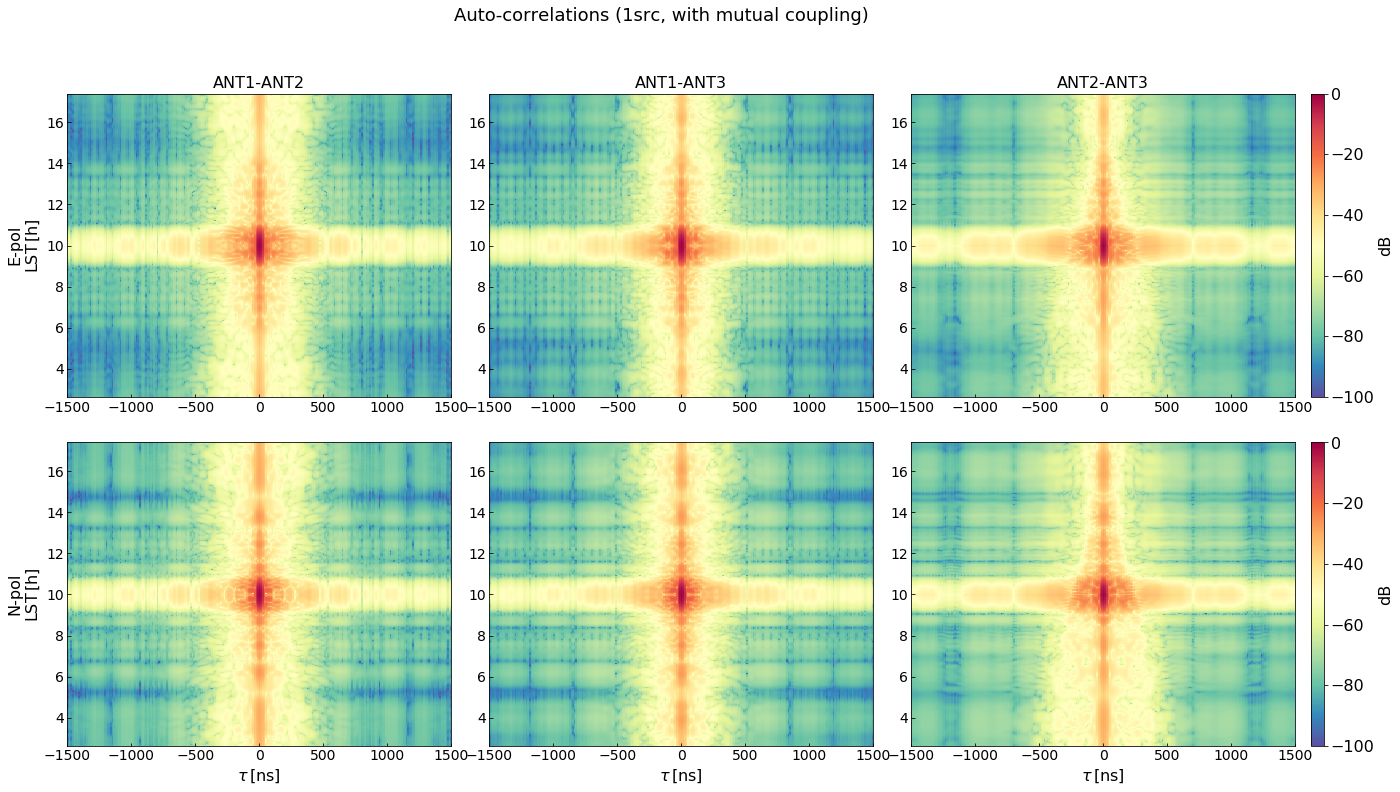

In [13]:
delayspec_plotter(F_autos_cc1,t1_g,lst1_g,None,cross_str,r'Auto-correlations (1src, with mutual coupling)')

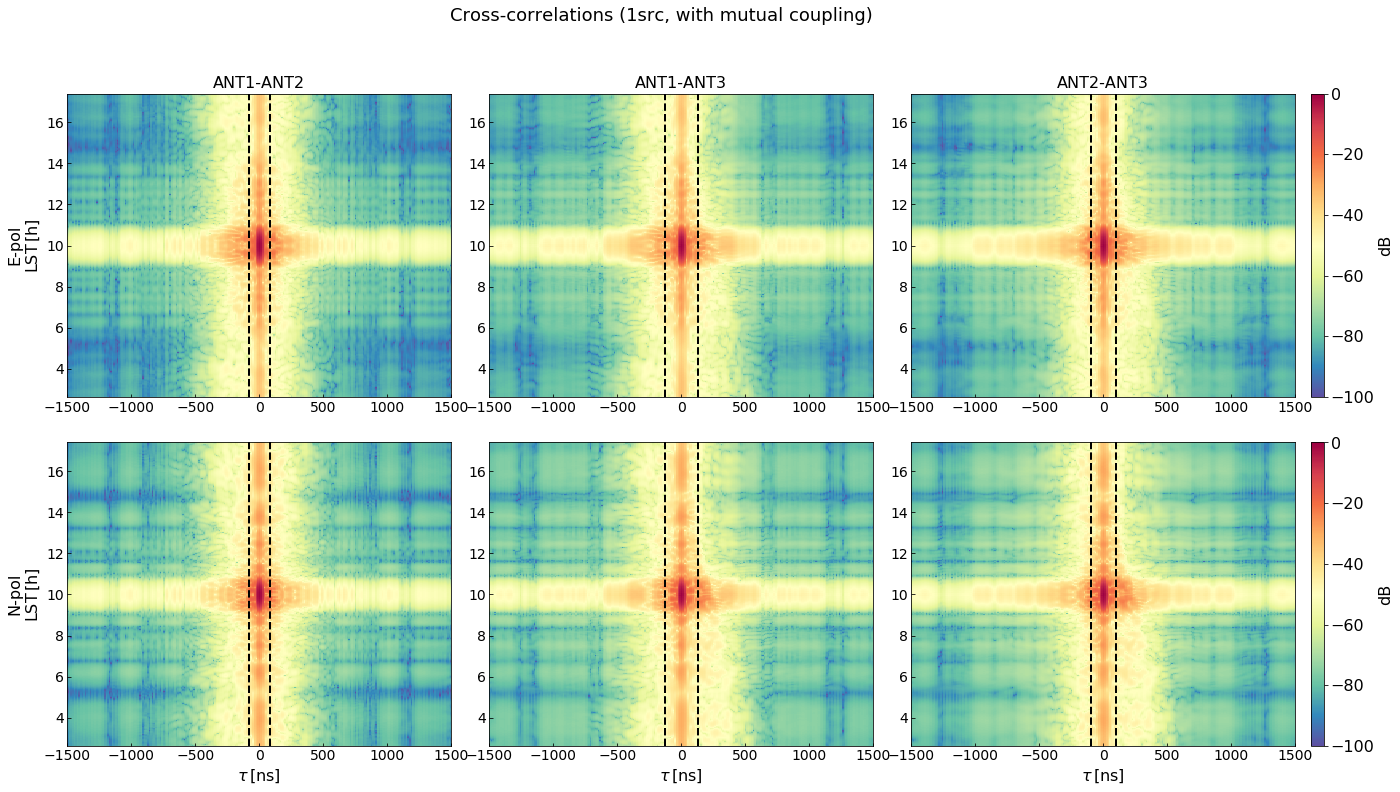

In [14]:
delayspec_plotter(F_cross_cc1,t1_g,lst1_g,bls,cross_str,r'Cross-correlations (1src, with mutual coupling)')

In [ ]:
delayspec_plotter(F_autos_cc2,t2_g,lst2_g,None,autos_str,r'Auto-correlations (2src, with mutual coupling)')

In [ ]:
delayspec_plotter(F_cross_cc2,t2_g,lst2_g,bls,cross_str,r'Cross-correlations (2src, with mutual coupling)')

In [22]:
def calculate_delayrate_spec(autos, cross, lsts):
    
    window = signal.blackmanharris(len(lsts))[np.newaxis,np.newaxis,:,np.newaxis]
    
    F_autos = fftshift(fft(autos*window,axis=2),axes=2)
    F_cross = fftshift(fft(cross*window,axis=2),axes=2)
    
    tau = fftshift(fftfreq(len(lsts),d=lsts[1]-lsts[0]))

    return F_autos, F_cross, tau/3600.

In [23]:
FF_autos_nocc2, FF_cross_nocc2, ft2 = calculate_delayrate_spec(F_autos_nocc2, F_cross_nocc2, lst_2src)
FF_autos_cc2, FF_cross_cc2, ft2 = calculate_delayrate_spec(F_autos_cc2, F_cross_cc2, lst_2src)

In [25]:
tf2_g, ft2_g = np.meshgrid(tau*1.e9,ft2)

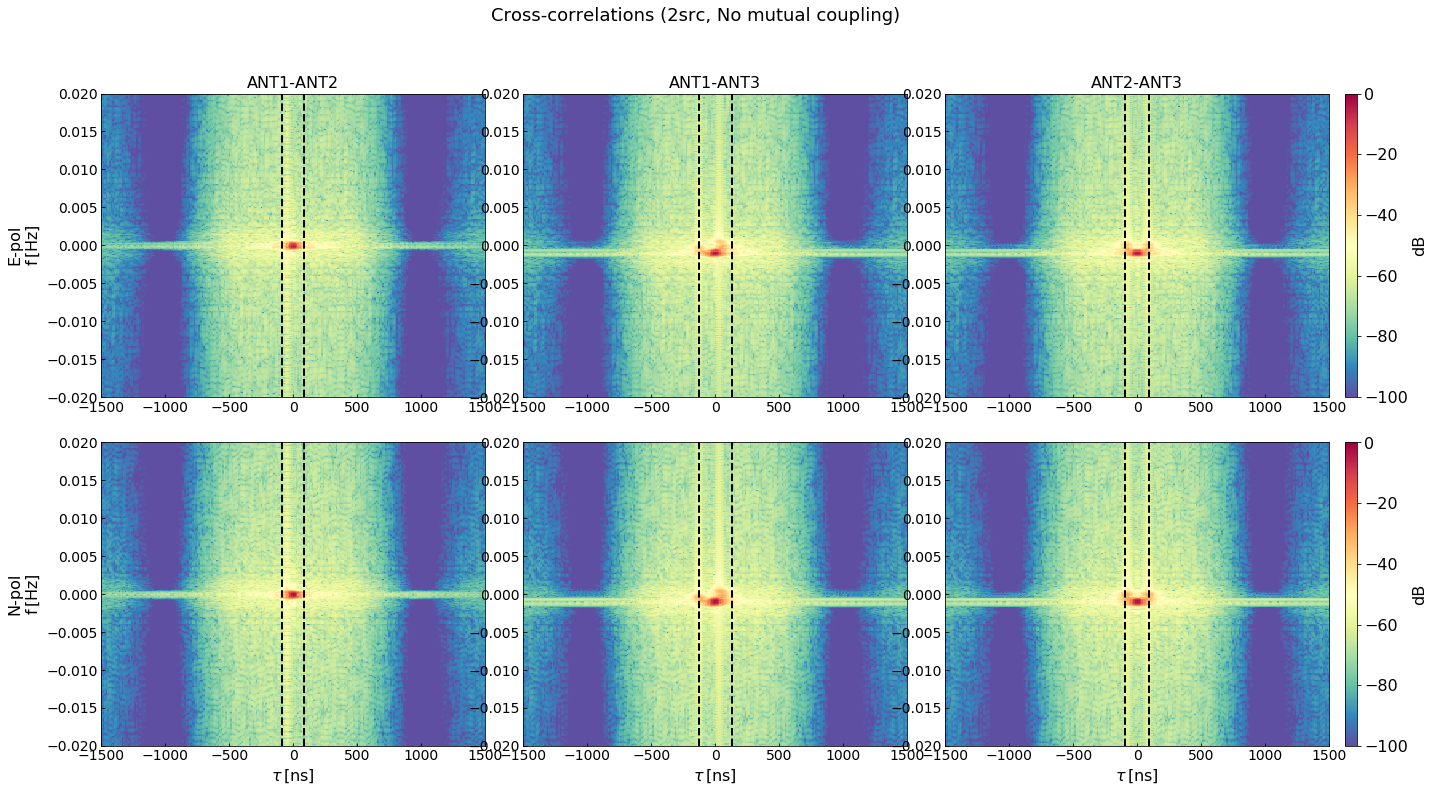

In [52]:
delayrate_spec_plotter(FF_cross_nocc2,tf2_g,ft2_g,bls,cross_str,r'Cross-correlations (2src, No mutual coupling)')

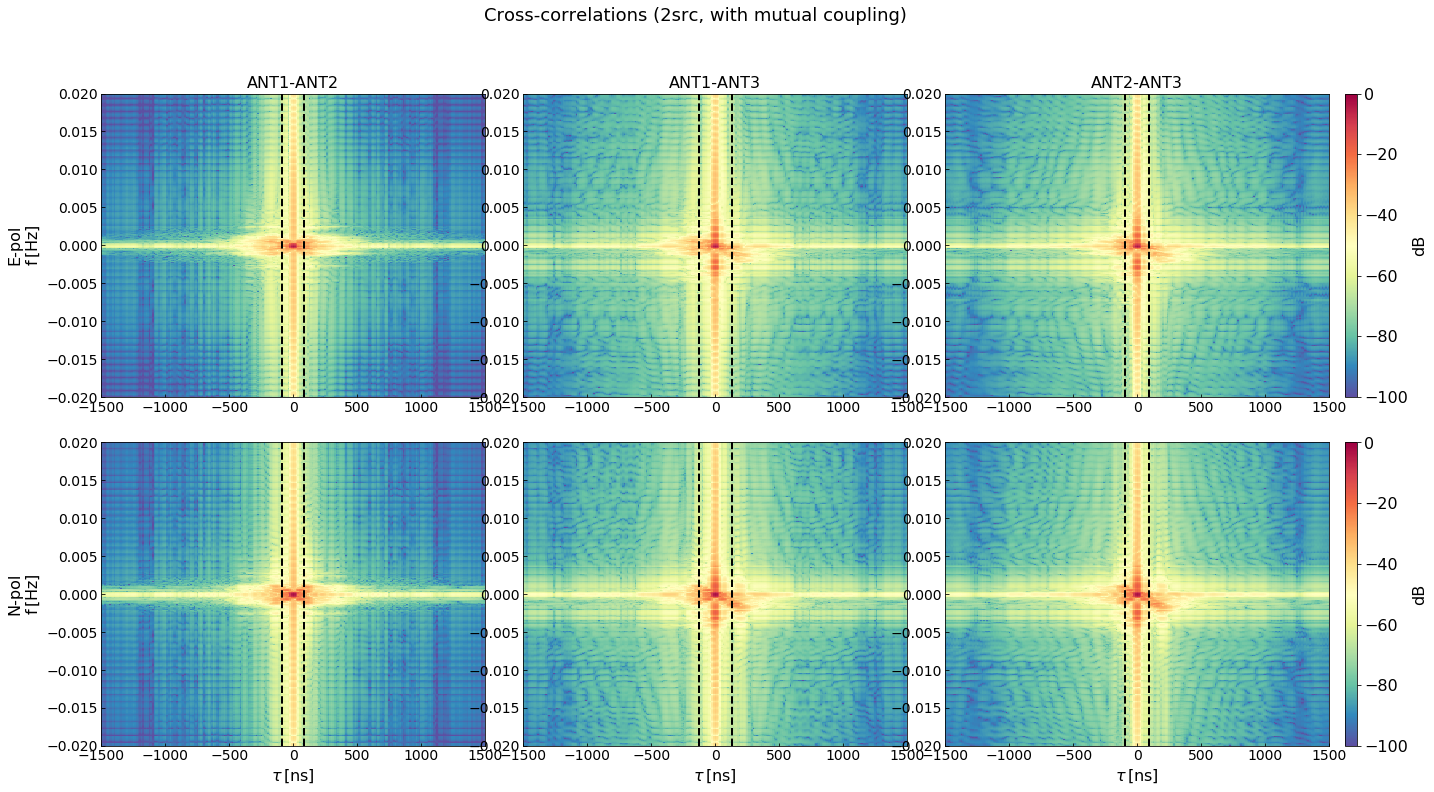

In [53]:
delayrate_spec_plotter(FF_cross_cc2,tf2_g,ft2_g,bls,cross_str,r'Cross-correlations (2src, with mutual coupling)')